# Imports

In [82]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
import random

from numpy.random import randint
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError, CategoricalCrossentropy
from tensorflow.keras.initializers import  HeNormal

from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.layers import (
  Input, Conv2D, Conv2DTranspose, LeakyReLU, ReLU, Flatten, Dense,
  Activation, Concatenate, BatchNormalization, ZeroPadding2D
)
from glob import glob
from tensorflow.keras import activations
from tensorflow.keras.models import Model
from tqdm.notebook import tqdm
from skimage.color import rgb2lab, lab2rgb
from tensorflow.keras import initializers

from tensorflow_addons.layers import InstanceNormalization, SpectralNormalization
%matplotlib inline

In [83]:
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

config = tf.compat.v1.ConfigProto(
  gpu_options=tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8)
)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

# Constants

In [ ]:
# ----- model config -----
dataset_dir = "./dataset_with_deepcrack"
labels = ["crack"]
weight_init = initializers.GlorotNormal()
weight_regularizer = None
image_shape = (128, 128, 3)
SIZE=image_shape[0]

ch = 64                                         # default filter depth for the conv blocks
n_dis = 6                                       # number of covolution in the block of discriminator
c_dim = len(labels) + 1                         # number of domains for image translation, crack, water_seepage,     normal 
n_res = 6                                       # number of res_block in bottleneck of image-to-image module


noise_dim = (128,128,3)


# ----- training config -----
buffer_size = 1000
batch_size=1

lr = 1e-4
n_disc_iteration = 1                            # critic iteration before update of generator


# Model Definitions

In [ ]:
def spectral_norm(w, iteration=1):
  w_shape = w.shape.as_list()
  w = tf.reshape(w, [-1, w_shape[-1]])

  u = tf.compat.v1.get_variable("u", [1, w_shape[-1]], initializer=tf.random_normal_initializer(), trainable=False)

  u_hat = u
  v_hat = None

  for i in range(iteration):
    """
    power iteration
    Usually iteration = 1 will be enough
    """
    v_ = tf.linalg.matmul(u_hat, tf.transpose(w))
    v_hat = tf.math.l2_normalize(v_)

    u_ = tf.linalg.matmul(v_hat, w)
    u_hat = tf.math.l2_normalize(u_)

  u_hat = tf.stop_gradient(u_hat)
  v_hat = tf.stop_gradient(v_hat)

  sigma = tf.linalg.matmul(tf.linalg.matmul(v_hat, w), tf.transpose(u_hat))

  with tf.control_dependencies([u.assign(u_hat)]):
    w_norm = w / sigma
    w_norm = tf.reshape(w_norm, w_shape)

  return w_norm

In [27]:
def conv(x_init, filters, kernel_size=4, strides=2, pad=0, pad_type='zero', use_bias=True, sn=False):
  x = ZeroPadding2D(padding=(pad, pad))(x_init)
  if sn:
    w = tf.compat.v1.get_variable("kernel", shape=[kernel_size, kernel_size, x.get_shape()[-1], channels], initializer=weight_init,
                        regularizer=weight_regularizer)
    x = Conv2D(input=x, filter=spectral_norm(w),
               strides=[1, strides, strides, 1], padding='VALID')
    if use_bias:
        bias = tf.get_variable("bias", [filters], initializer=tf.constant_initializer(0.0))
        x = tf.nn.bias_add(x, bias)

  else:
    x = Conv2D(filters, kernel_size=(kernel_size,kernel_size), kernel_initializer=weight_init, kernel_regularizer=weight_regularizer, strides=(strides,strides), use_bias=use_bias)(x)
  return x


In [28]:
def deconv(x, filters, kernel_size=4, strides=2, use_bias=True):
  x = Conv2DTranspose(filters=filters, 
                      kernel_size=kernel_size, 
                      kernel_initializer=weight_init, 
                      kernel_regularizer=weight_regularizer,
                      strides=strides, 
                      padding='same', 
                      use_bias=use_bias)(x)
  return x

In [29]:
def discriminator():
  channel = ch
  input = Input(shape=(image_shape))
  x = conv(input, channel, kernel_size=4, strides=2, pad=1, use_bias=True)
  x = LeakyReLU(0.01)(x)

  for i in range(1, n_dis):
    x = conv(x, channel * 2, kernel_size=4, strides=2, pad=1, use_bias=True)
    x = LeakyReLU(0.01)(x)

    channel = channel * 2

  c_kernel = int(image_shape[0] / np.power(2, n_dis))

  logit = conv(x, 1, kernel_size=3, strides=1, pad=1, use_bias=False)
  c = conv(x, c_dim, kernel_size=c_kernel, strides=1, use_bias=False)
  c = tf.reshape(c, shape=[-1, c_dim])
  c = Dense(c_dim, activation="softmax")(c)
  
  output = [logit, c]
  model = Model(input, output)
  
  return model

In [30]:
disc = discriminator()

In [31]:
x = tf.random.normal((1,)+image_shape, 0, 1)
print(disc(x)[0].shape)
print(disc(x)[1].shape)

(1, 2, 2, 1)
(1, 2)


In [32]:
def res_block(x_in, filters, use_bias=True, scope='resblock'):
  input = x_in
  x = conv(input, filters, kernel_size=3, strides=1, pad=1, use_bias=use_bias)
  x = InstanceNormalization()(x)
  x = ReLU()(x)
  x = conv(x, filters, kernel_size=3, strides=1, pad=1, use_bias=use_bias)
  x = InstanceNormalization()(x)
  return x + input

In [33]:
def down_sample(x, scale_factor_h, scale_factor_w):
  _, h, w, _ = x.get_shape().as_list()
  new_size = [h // scale_factor_h, w // scale_factor_w]
  return tf.image.resize(x, new_size, method='nearest')

def param_free_norm(x, epsilon=1e-5):
  x_mean, x_var = tf.nn.moments(x, axes=[1, 2])
  x_std = tf.sqrt(x_var + epsilon)
  return (x - x_mean) / x_std

def spade(segmap, x_init, filters=None, use_bias=True, sn=False) :
  x = param_free_norm(x_init)

  _, x_h, x_w, n_filters = x_init.get_shape().as_list()
  _, segmap_h, segmap_w, _ = segmap.get_shape().as_list()
  
  factor_h = segmap_h // x_h  # 256 // 4 = 64
  factor_w = segmap_w // x_w

  segmap_down = down_sample(segmap, factor_h, factor_w)

  segmap_down = conv(segmap_down, filters=128, kernel_size=5, strides=1, pad=2, use_bias=use_bias, sn=sn)
  segmap_down = ReLU()(segmap_down)

  segmap_gamma = conv(segmap_down, filters=filters, kernel_size=5, strides=1, pad=2, use_bias=use_bias, sn=sn)
  segmap_beta = conv(segmap_down, filters=filters, kernel_size=5, strides=1, pad=2, use_bias=use_bias, sn=sn)

  x = x * (1 + segmap_gamma) + segmap_beta

  return x

In [34]:
def spade_resblock(segmap, x_init, filters, use_bias=True, sn=False):
  channel_in = x_init.get_shape().as_list()[-1]
  channel_middle = min(channel_in, filters)

  x = spade(segmap, x_init, channel_in, use_bias=use_bias, sn=False)
  x = LeakyReLU(0.2)(x)
  x = conv(x, filters=channel_middle, kernel_size=3, strides=1, 
           pad=1, use_bias=use_bias, sn=sn)
  x = spade(segmap, x, filters=channel_middle, use_bias=use_bias, 
            sn=False)
  x = LeakyReLU(0.2)(x)
  x = conv(x, filters=filters, kernel_size=3, strides=1, pad=1, 
           use_bias=use_bias, sn=sn)

  if channel_in != filters:
    x_init = spade(segmap, x_init, filters=channel_in, use_bias=use_bias, sn=False)
    x_init = conv(x_init, filters=filters, kernel_size=1, strides=1, 
                  use_bias=False, sn=sn)
  return x + x_init

In [35]:
def adative_noise_multiplier(z):
  x = Conv2D(32, (5,5), 2, padding="same")(z)
  x = ReLU()(x)
  x = Conv2D(64, (3,3), 2, padding="same")(x)
  x = ReLU()(x)
  x = Flatten()(x)
  x = Dense(128, activation="relu")(x)
  x = Dense(1, activation="sigmoid")(x)
  
  return x

In [36]:
def generator():
    channel = ch
    x_in = Input(shape=image_shape)
    c_in = Input(shape=(image_shape[0], image_shape[1], c_dim))
    z = Input(shape=noise_dim)
    lambda_z = adative_noise_multiplier(z)
    x = tf.concat([x_in, lambda_z * z], axis=-1)
    # in the past, c_in is of shape (c_dim,), now c_in has also the spacial information, therefore no need to tf.tile(c_in, [1, x_in.shape[1], x_in.shape[2], 1])   
    x = conv(x, channel, kernel_size=7, strides=1, pad=3, use_bias=False)
    x = InstanceNormalization()(x)
    x = ReLU()(x)
    

    # Down-Sampling
    for i in range(2):
      x = conv(x, channel*2, kernel_size=4, strides=2, pad=1, use_bias=False)
      x = InstanceNormalization()(x)
      x = ReLU()(x)

      channel = channel * 2

    # Bottleneck
    for i in range(n_res):
      x = res_block(x, channel, use_bias=False)

    # Up-Sampling
    for i in range(2):
      # need to feed the spatial control map here
      x = deconv(x, channel//2, kernel_size=4, strides=2, use_bias=False)
      # spade normalization instead
      x = spade_resblock(c_in, x, channel//2)
      x = ReLU()(x)

      channel = channel // 2
          
    pre_mask = conv(x, filters=1, kernel_size=7, strides=1, pad=3, use_bias=False)
    mask = Activation("sigmoid")(pre_mask)
    
    pre_defect_overlay = conv(x, filters=3, kernel_size=7, strides=1, pad=3, use_bias=False)
    defect_overlay = Activation("tanh")(pre_defect_overlay)
    
    model = Model([x_in, c_in, z], [defect_overlay, mask])
    return model

In [37]:
gen = generator()

# Dataset Pipeline

In [38]:
import glob

In [39]:
def one_hot(index, length):
  zeros = np.zeros((length, ))
  zeros[index] = 1
  return zeros

In [40]:
def get_segment_and_spatialCatMap_and_defectOneHot_and_normalOnehot(segment_filepath, index):  
  # only EagerTensor can be decoded as follows:
  index = int(bytes.decode(index))
  segment_filepath = bytes.decode(segment_filepath)
  segment = img_to_array(load_img(segment_filepath, target_size=(SIZE,SIZE), color_mode="grayscale"))
  segment = np.where(segment>0.5, 1, 0)
  
  spatial_cat_map = np.zeros((SIZE, SIZE, c_dim))
  
  # create spatial_categorical map from segmentation and index of the defect class
  
  for x in range(SIZE):
    for y in range(SIZE):
      if segment[x,y,0] > 0:
        spatial_cat_map[x,y,index] = 1
  
  defect_onehot = one_hot(index, c_dim)
  normal_onehot = one_hot(c_dim-1, c_dim) # onehot with last entry as 1, else 0
      
  return tf.convert_to_tensor(segment, dtype=tf.float32), \
          tf.convert_to_tensor(spatial_cat_map, dtype=tf.float32), \
          tf.convert_to_tensor(defect_onehot, dtype=tf.float32),\
          tf.convert_to_tensor(normal_onehot, dtype=tf.float32)

In [57]:
import random

def path_to_img(zipped_filepaths):
  normal_filepath = zipped_filepaths[0]
  defect_filepath = zipped_filepaths[1]
  segment_filepath = zipped_filepaths[2]
  defect_index = zipped_filepaths[3]
  
  normal = tf.io.read_file(normal_filepath)
  normal = tf.image.decode_png(normal, channels=3)
  normal = tf.image.resize(normal, (SIZE, SIZE))
  normal = (normal/127.5) - 1
  
  
  defect = tf.io.read_file(defect_filepath)
  defect = tf.image.decode_png(defect, channels=3)
  defect = tf.image.resize(defect, (SIZE, SIZE))
  defect = (defect/127.5) - 1
  
  
  segment, spatial_cat_map, defect_onehot, normal_onehot = tf.numpy_function(
                                                 func=get_segment_and_spatialCatMap_and_defectOneHot_and_normalOnehot, 
                                                 inp=[segment_filepath, defect_index], 
                                                 Tout = [tf.float32, tf.float32, tf.float32, tf.float32]
                                                )
      
  return (normal, defect, segment, defect_index, spatial_cat_map, defect_onehot, normal_onehot)

def get_normal_defect_defectSegment_defectIndex_spatialCat_defectOneHot_normalOnehot_gen(random_segmentations=False):
  normals = []
  defects = []
  defect_segmentations = []
  defect_indexes = []

  for label in labels:
    index = labels.index(label)
    normals += glob.glob(f"{dataset_dir}/{label}/normal/*.jpg")
    defects += glob.glob(f"{dataset_dir}/{label}/defect/*.jpg")
    defect_segmentations += glob.glob(f"{dataset_dir}/{label}/defect_segmentation/*.png")
    
    if random_segmentations:
      random.shuffle(defect_segmentations)
      
    defect_indexes += [str(index)] * len(normals) # normals, defects, defect_segementations are all of the same length, just use one of them
    
  normal_defect_defectSeg = list(zip(normals, defects, defect_segmentations, defect_indexes))
  dataset = tf.data.Dataset.from_tensor_slices(normal_defect_defectSeg)\
              .map(path_to_img)\
              .batch(batch_size)\
              .shuffle(buffer_size)\
              .cache()

  return iter(dataset)



label crack


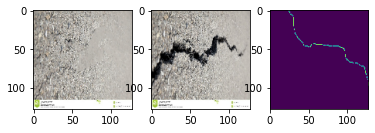

In [58]:
def view_dataset_sample():
  normals, defects, segments, indexes, spatial_cat_maps, _, _ = next(get_normal_defect_defectSegment_defectIndex_spatialCat_defectOneHot_normalOnehot_gen(random_segmentations=True))
  #   spatial_cat_map_[:,:,index] = segments
  for i in range(0, 1):
    normal = normals[i].numpy().astype("float32")
    defect = defects[i].numpy().astype("float32")
    segment = segments[i].numpy().astype("float32")
    spatial_cat_map = spatial_cat_maps[i]
    index = int(indexes[i])
    label = labels[index]
    
    print("label", label)
    plt.figure(figsize=(6, 15))

    plt.subplot(1, 3, 1)
    plt.imshow(((normal+1)*127.5).astype("uint8"))

    plt.subplot(1, 3, 2)
    plt.imshow(((defect+1)*127.5).astype("uint8"))

    plt.subplot(1, 3, 3)
    plt.imshow(spatial_cat_map[:,:,index])
    
view_dataset_sample()

# Train Loop with Helper Function to see Intermediate Performance

In [43]:
mae = MeanAbsoluteError()
cce = CategoricalCrossentropy()

In [44]:
gen = generator()
disc = discriminator()             

max mask value inside mask: 0.98844796


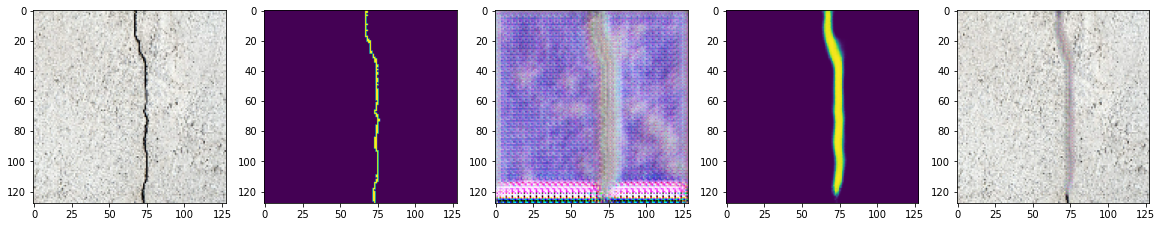

max mask value inside mask: 0.99875426


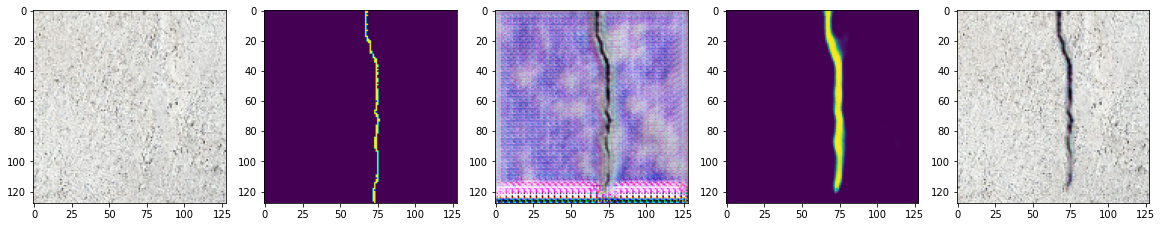

max mask value inside mask: 0.99962103


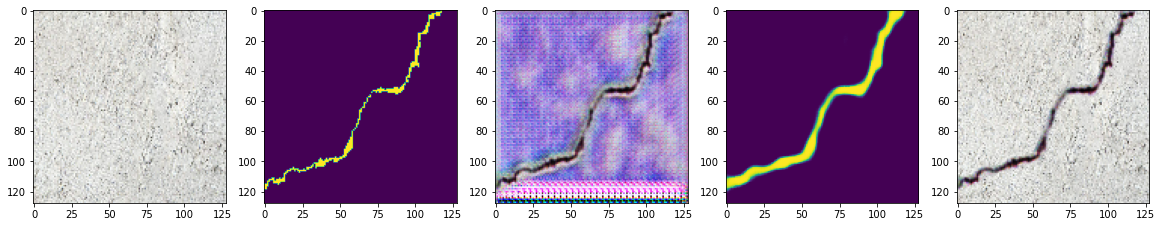

In [75]:
def view_generator_sample(image_name=None, show_in_notebook=True):
  datagen = get_normal_defect_defectSegment_defectIndex_spatialCat_defectOneHot_normalOnehot_gen()
  dategen_randomSeg = get_normal_defect_defectSegment_defectIndex_spatialCat_defectOneHot_normalOnehot_gen(random_segmentations=True)

  normals, defects, segments, indexes, spatial_cat_maps, _, _ = next(datagen)
  normals_, defects_, segments_, indexes_, spatial_cat_maps_, _, _ = next(dategen_randomSeg)
  #   spatial_cat_map_[:,:,index] = segments
  
  if image_name is not None:
    print("")
    print("---------------------------------------------")
    print("---------")
    print(image_name)
    
  for i in range(0, 1):
    spatial_cat_map_randomSeg = spatial_cat_maps_[i]
    
    spatial_cat_map = spatial_cat_maps[i]
    normal = normals[i].numpy().astype("float32")
    
    defect = defects[i].numpy().astype("float32")
    
    for from_, spa_cat, description in [
      (defect, spatial_cat_map, "from_defect"), 
      (normal, spatial_cat_map, "from_normal"), 
      (normal, spatial_cat_map_randomSeg, "from_random_segment")
    ]:
      segment = segments[i].numpy().astype("float32")
      z = np.random.normal(0, 1, (1, )+noise_dim)

      top, m = gen.predict([from_[np.newaxis,...], spa_cat[np.newaxis,...], z])

      top_layer = np.squeeze(top)


      index = int(indexes[i])
      label = labels[index]

      plt.figure(figsize=(20, 20))

      plt.subplot(1, 5, 1)
      plt.imshow(((from_+1)*127.5).astype("uint8"))

      plt.subplot(1, 5, 2)
      plt.imshow(spa_cat[:,:,index])


      plt.subplot(1, 5, 3)

      plt.imshow(((top_layer+1)*127.5).astype("uint8"))

      plt.subplot(1, 5, 4)
      print("max mask value inside mask:", np.amax(m))
      plt.imshow(np.squeeze(m))

      plt.subplot(1, 5, 5)
      gened_defects = from_ * (1-m)  + top_layer * m
      plt.imshow(((gened_defects[0]+1)*127.5).astype("uint8"))


      if image_name is not None:
        plt.savefig(f"{image_name}_{description}", dpi=140, bbox_inches="tight")
        
      if show_in_notebook:
        plt.show()
  
view_generator_sample()

In [46]:
def gradient_penality(critic, real_sample, fake_sample):
    epsilon = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
    interpolated = epsilon * real_sample + (1 - epsilon) * fake_sample

    with tf.GradientTape() as gp_tape:
      gp_tape.watch(interpolated)
      critic_inter = critic(interpolated, training=True)

    grads = gp_tape.gradient(critic_inter, [interpolated])[0]
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
    penality = tf.reduce_mean((norm - 1.0) ** 2)
    return penality

In [76]:
def train(epoches=40, sample_per_batch=15):
  
  g_opt = Adam(lr=lr, beta_1=0, beta_2=0.9)
  d_opt = Adam(lr=lr, beta_1=0, beta_2=0.9)
  
  
  for epoch in range(epoches):
    batch = 0
    dataset_gen = get_normal_defect_defectSegment_defectIndex_spatialCat_defectOneHot_normalOnehot_gen()
    
    for normals, defects, _, _, spatial_cat_maps, defect_onehots, normal_onehots in dataset_gen:
      batch += 1
      print("epoch", epoch+1, "batch", batch, end="\r")
      
      for iteration in range(n_disc_iteration):
        update_gen = (iteration+1)%n_disc_iteration == 0

        for from_, to_, from_onehots, target_onehots in [(normals, defects, normal_onehots, defect_onehots), (defects, normals, defect_onehots, normal_onehots)]:
          z_1 = tf.random.normal((1,)+noise_dim, 0, 1)
          z_2 = tf.random.normal((1,)+noise_dim, 0, 1)

          with tf.GradientTape(persistent=True) as tape:
            # naming convetion is from normal --> defect. Roles of normal and defect can be interchanged
            defect_overlays, n2d_masks = gen([from_, spatial_cat_maps, z_1], training=True)
            gened_defects = from_ * (1-n2d_masks)  + defect_overlays * n2d_masks

            restore_overlays, d2n_masks = gen([gened_defects, spatial_cat_maps, z_2], training=True)
            restoration = gened_defects * (1-d2n_masks) + restore_overlays * d2n_masks

            d_logit_on_gened, d_cls_on_gened = disc(gened_defects, training=True)
            d_logit_on_real, d_cls_on_real = disc(from_, training=True)

            cls_loss_on_gened = cce(target_onehots, d_cls_on_gened)
            cls_loss_on_real = cce(from_onehots, d_cls_on_real)

            gp = gradient_penality(disc, from_, gened_defects)

            d_wgan_gp_loss = tf.math.reduce_mean(d_logit_on_gened) - tf.reduce_mean(d_logit_on_real) + 10 * gp


            g_cycle_loss = mae(from_, restoration)

            g_mask_cycle_loss = mae(n2d_masks, d2n_masks)

            g_mask_vanishing_loss = -tf.math.log(tf.math.reduce_mean(mae(n2d_masks, 0.0) +  mae(d2n_masks, 0.0))) 
            g_mask_spatial_constraint_loss = tf.math.reduce_mean(mae(n2d_masks, 0.0) +  mae(d2n_masks, 0.0))

            g_wgan_gp_loss = - tf.math.reduce_mean(d_logit_on_gened)

            d_loss = tf.tensordot(
              [1,              5.0             ],
              [d_wgan_gp_loss, cls_loss_on_real],
              axes = 1
            )

            if update_gen:
              g_loss = tf.tensordot(
                [10.0,         5.0,               0.5,                   5.0,                            10.0,               1.0           ],
                [g_cycle_loss, g_mask_cycle_loss, g_mask_vanishing_loss, g_mask_spatial_constraint_loss, cls_loss_on_gened, g_wgan_gp_loss],
                axes = 1
              )
              
          grad_of_d = tape.gradient(d_loss, disc.trainable_variables)
          d_opt.apply_gradients(zip(grad_of_d, disc.trainable_variables))

          if update_gen:
            grad_of_g = tape.gradient(g_loss, gen.trainable_variables)
            g_opt.apply_gradients(zip(grad_of_g, gen.trainable_variables))

      
      if (batch % sample_per_batch) == 0:
        view_generator_sample(
          image_name="epoch_{}_batch_{}".format(
          str(epoch+1).zfill(3), 
          str(batch).zfill(5)
        ))

In [ ]:
train(epoches=40, sample_per_batch=15)

In [78]:
gen.save("./defect-gan-01.h5")